In [1]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot, prettify_2d_plot
import numpy as np
from numpy import abs, exp, pi

###################################   CONSTANTS   ####################################
n_hbn = 2.2
n_si = 3.881 - .019j
n_wse2 = 2
n_vac = 1

r1 = (n_vac - n_hbn)/(n_vac + n_hbn)
r2 = (n_hbn - n_vac)/(n_hbn + n_vac)
r3 = (n_vac - n_si)/(n_vac + n_si)

########## PHASE ACQUIRED IN HBN OF THICKNESS t  AND HOLE DEPTH d   ###################
def Phi(t, n_i, wvl):
    return 2*pi*n_i*t/wvl

################################# REFLECTANCE  ########################################
def R(t, d, wvl): 
    return abs(
        (
         r1*exp(1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r2*exp(-1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl))) + 
         r3*exp(-1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r1*r2*r3*exp(1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl)))
        )
            /
        (
         exp(1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r1*r2*exp(-1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl))) + 
         r1*r3*exp(-1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r2*r3*exp(1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl)))
        )
    )**2

<IPython.core.display.Javascript object>


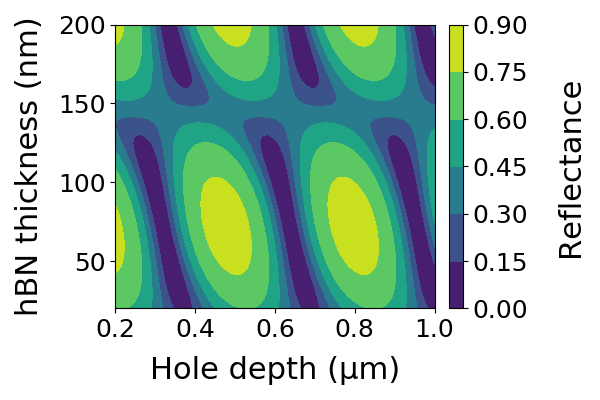

In [27]:
# reflectance versus hole depth
z = np.linspace(200e-9, 1000e-9, 100)
t_hbn = np.linspace(20e-9, 200e-9, 100)
lam = 637e-9
zz, tt = np.meshgrid(z, t_hbn)
reflect = R(tt, zz, lam) 
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
cp = ax.contourf(z*1e6, t_hbn*1e9, reflect)
cb = plt.colorbar(cp, fraction=0.046, pad=0.04)

prettify_2d_plot(ax, cb, 'Hole depth (μm)', 'hBN thickness (nm)','Reflectance')
fig.tight_layout()

<IPython.core.display.Javascript object>


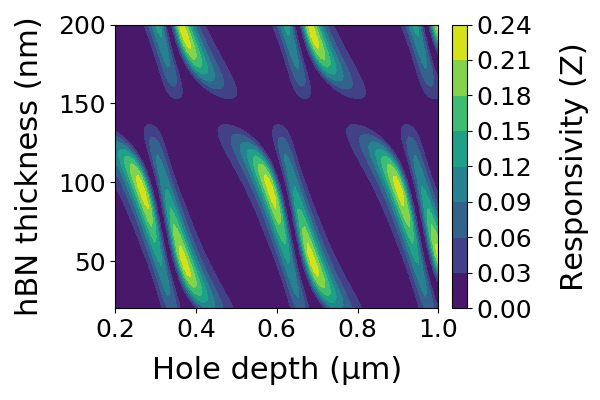

In [33]:
# displacement responsivity
disp = 10*abs(np.gradient(reflect))
fig2 = plt.figure(figsize=(6, 4))
ax1 = fig2.add_subplot(111)
cp1 = ax1.contourf(z*1e6, t_hbn*1e9, disp[1]*disp[0])
cb1 = plt.colorbar(cp1, fraction=0.046, pad=0.04)

# fig = plt.figure(figsize=(6, 4))
prettify_2d_plot(ax1, cb1, 'Hole depth (μm)', 'hBN thickness (nm)','Responsivity (Z)')
fig2.tight_layout()